# Report for CitiBike Usage Forecast: Regression Model


This report provides an analysis of the impact of weather conditions on ridership numbers in New York City's Citi Bike-sharing program. The fluctuations in ridership and the role of weather conditions as a major contributing factor are explored. The report highlights how various weather conditions, such as extreme temperatures, rain, snow, and wind, affect the usage of the Citi Bike-sharing program. 

Introduction: 

* The report introduces New York City's Citi Bike-sharing program as a popular transportation mode for commuters and tourists since its launch in 2013. 

* It highlights the significant fluctuations observed in ridership numbers over time and establishes weather conditions as a key contributing factor to these fluctuations. 

Impact of Weather Conditions: 

* New York City experiences a diverse range of weather conditions throughout the year, including extreme temperatures, rain, snow, and wind. 

* The report discusses how these weather conditions have a notable impact on the number of riders utilizing the Citi Bike-sharing program. 

* During winter months, colder temperatures and snowfall tend to result in lower ridership numbers as people may opt for alternative transportation modes. 

* Similarly, hot summer months can also lead to reduced ridership due to the discomfort caused by extreme heat. 

Seasonal Trends: 

* The report highlights the seasonal trends observed in ridership numbers and their correlation with specific weather conditions. 

* It emphasizes that understanding these trends is crucial for effective resource planning and allocation in the Citi Bike-sharing program. 

Data and Analysis: 

* The report discusses the data sources and analysis techniques used to assess the impact of weather conditions on ridership numbers. 

* It may include statistical analyses, data visualization, and correlation studies to support the findings. 

## Initialization

In [1]:
%pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
import  pyspark.sql.functions as F
import pandas as pd
import pyspark.ml.feature as MF
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor
from google.cloud import storage
import pyspark.ml.feature as MF
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import random
import csv 
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime
from geopy.distance import geodesic as GD
import seaborn as sns


In [3]:


spark = SparkSession.builder.getOrCreate() 


client = storage.Client()
BUCKET_NAME = 'nikhil_final_project'
bucket = client.get_bucket(BUCKET_NAME)
elements = bucket.list_blobs()  #Get all files and folders in Bucket
storage_files=[a.name for a in elements] # Create a list of files names present in bucket

PATH = "gs://nikhil_final_project/final_dataset/" # Path to dataset Folder
BUCKET_PATH = "gs://nikhil_final_project/" # Path to bucket

# DataSet Creation

This part of code is for creation of our final dataset.

Citibike Dataset
- We begin with 86 individual files of citibike with each file containing one months data
- We take data from Jan 2015 to Dec 2022.
- Each row has information of a single ride that took place from any of the 2030 Citibike stations
- Citibike also kept changing their file format (3 file formats, 5 datetime formats) which needed to be formatted properly to get a consistent final dataset
- We used group by on station name and date to create the final dataset in a per day, per station basis and collection information such as average ride count, average ride duration, location of station etc.

Weather Dataset
- We have 20 weather nodes in and around New York city, each node was its own sepearte file.
- Each file had per day summary of weather for its location for date range same as citibike.
- The file format was consistent so we could directly load the entire folder into a dataframe using sparks read_csv function

Final Dataset
- We merged the two above dataframes by first creating a intermediate dataframe consisting of mapping between a citibikes station and its neareast weather node.
- We created this mapping using geopy module to determine the distance between two locations.
- We LeftOuter Joined the intermediate dataframe with citibikes dataframe on key=station_name
- We then had each citibike row having information of its nearest weather node.
- Finally we LeftOuter Joined Citibike and weather dataframe on keys = Date & weathernode name


In [97]:
def get_data_create(name, df_type):
    # This function reads csv to create dataframe
    # Datetime format is different based on dataset type
    final_path = PATH+name
    if df_type == 1:
        dt_format = "yyyy-MM-dd HH:mm:ss.SSSS"
    elif df_type == 2:
        dt_format = "yyyy-MM-dd HH:mm:ss"
    elif df_type == 3:
        dt_format = "M/d/yyyy H:mm"
    elif df_type == 4:
        dt_format = "M/d/yyyy HH:mm:ss"
    elif df_type == 5:
        dt_format = "yyyy-MM-dd"
    
        
    data = spark.read.csv(
        path=final_path,
        sep=",",
        header=True,
        inferSchema=True,
        timestampFormat=dt_format)
    return data
    

def format_citi_dataset_1(df):
    # This function converts dataframe into final standard format
    # We standardize all column names, convert each start time to only contain date
    # Group by those dates + station and calculate means and count to get daily summary of each station
    df1 = (
         df.withColumn("starttime", F.to_date(F.col("starttime"), "yyy-MM-dd"))
        .groupBy("starttime", F.col("start station id").alias("start_station_name"))
        .agg(
            F.mean("tripduration").alias("tripduration_mean"),
            F.count("tripduration").alias("total_count"),
            F.mean("start station latitude").alias("start_lat"),
            F.mean("start station Longitude").alias("start_lng")
            )
    )
    return df1

def format_citi_dataset_2(df):
    # This function converts dataframe into final standard format
    # We standardize all column names, convert each start time to only contain date
    # Group by those dates + station and calculate means and count to get daily summary of each station
    df1 = (
        df.withColumn("tripduration",
                       F.col("ended_at").cast("long") - F.col("started_at").cast("long"))
        .withColumn("starttime", F.to_date(F.col("started_at"), "yyy-MM-dd"))
        .groupBy("starttime", F.col("start_station_id").alias("start_station_name"))
        .agg(
            F.mean("tripduration").alias("tripduration_mean"),
            F.count("tripduration").alias("total_count"),
            F.mean("start_lat").alias("start_lat"),
            F.mean("start_lng").alias("start_lng")
            )
    )       
    
    return df1

def format_citi_dataset_3(df):
    # This function converts dataframe into final standard format
    # We standardize all column names, convert each start time to only contain date
    # Group by those dates + station and calculate means and count to get daily summary of each station
    df1 = (
        df.withColumn("Trip Duration",
                       F.col("Stop Time").cast("long") - F.col("Start Time").cast("long"))
        .withColumn("starttime", F.to_date(F.col("Start Time"), "yyy-MM-dd"))
        .groupBy("starttime", F.col("Start Station id").alias("start_station_name"))
        .agg(
            F.mean("Trip Duration").alias("tripduration_mean"),
            F.count("Trip Duration").alias("total_count"),
            F.mean("Start Station Latitude").alias("start_lat"),
            F.mean("Start Station Longitude").alias("start_lng")
            )
    )       
    
    return df1

def get_dataset_type(name):
    #This function returns dataset and datetime type based on the name of the file
    if int(name[:4]) < 2021:
        if int(name[:4]) == 2015:
            if int(name[4:6]) == 6:
                return 3, 1
            elif int(name[4:6]) < 4:
                return 3, 1
            else:
                return 4, 1
        elif int(name[:4]) == 2016:
            if int(name[4:6]) < 10:
                return 4, 1
            else:
                return 2, 3
        elif int(name[:4]) == 2017:
            if int(name[4:6]) < 4:
                return 2, 3
            else:
                return 2, 1
        else:
            return 1, 1
    elif int((name[:4])) > 2021:
        return 2, 2
    elif int((name[:4])) == 2021:
        if int(name[4:6]) < 2:
            return 1, 1
        else:
            return 2, 2
    else:
        return 0,0

def merge_citi_dataset():
    # This is a wrapper function which reads all citybike datasets, formats them and merges them to get final citibike dataset.
    citi_files = []
    for file in storage_files: #From all files in GCP storage, create list of citibike files
        if "citibike-tripdata" in (file):
            citi_files.append(file)
    file_1 = citi_files[0] # Read first file to create a df to which we can append all other dfs
    d_type, f_type = get_dataset_type(file_1.split('/')[1]) #Get dataset and datetime type from dataset name 
    final_df = get_data_create(file_1, d_type) # read file storage as df
    
    #Convert file based on type
    if f_type == 1:
        final_df = format_citi_dataset_1(final_df)
    elif f_type == 2:
        final_df = format_citi_dataset_2(final_df)
    else:
        final_df = format_citi_dataset_3(final_df)
    
    #Do the above same process for all files
    for file in citi_files[1:]:
        d_type, f_type = get_dataset_type(file.split('/')[1])
        df = get_data_create(file, d_type)
        error = True
        for i in df.dtypes:
            if i[1] == "timestamp":
                error = False
        if error:
            raise Exception("Datetype not found")
        if f_type == 1:
            df = format_citi_dataset_1(df)
        elif f_type == 2:
            df = format_citi_dataset_2(df)
        else:
            df = format_citi_dataset_3(df)
        for i in df.dtypes:
            if i[0] == 'starttime' and i[1] != 'date':
                return "Error"
        
        final_df = final_df.union(df) # Use union to merge current dataframe to the final dataframe
    return final_df
  
def get_all_weather_datasets():
    # As weather datasets had consistent format, we can read entire folder into spark and spark will merge all csv files
    # into 1 dataframe
    final_df = get_data_create("weather", 5)
    final_df = final_df.withColumn("time", F.to_date(F.col("time"),"dd-MM-yyyy"))

    return final_df

def get_closest_node(station_location, weather_data):
    # This function compares station location with weather node location and returns closest weather nodes name.
    best_node = ""
    best_loc = ()
    min_dist = float('inf')
    
    for row in weather_data:
        node_loc = (row["LATITUDE"], row["LONGITUDE"])
        dist = GD(station_location, node_loc).km
        if dist < min_dist:
            best_node = row["Node"]
            best_loc = node_loc
            min_dist = dist

    return best_node
        

def create_station_matching_df(weather_df, citi_df):
    #This function creates a dataframe with all distinct citibike station names and its corresponding closest weather node
    match_data = []
    
    
    w_df1 = weather_df.groupBy("Node").agg(
            F.col("Node").alias("NAME"),
            F.mean("latitude").alias("LATITUDE"),
            F.mean("longitude").alias("LONGITUDE"),
    ).collect()
    
    c_df1 = citi_df.groupBy("start_station_name").agg(
            F.mean("start_lat").alias("start_lat"),
            F.mean("start_lng").alias("start_lng"),
    ).collect()
    
    for row in c_df1:
        s_loc = (row["start_lat"], row["start_lng"])
        node = get_closest_node(s_loc, w_df1)
        match_data.append([row["start_station_name"], node])
    
    match_df = spark.createDataFrame(data=match_data, schema = ["station_name","node_name"])
    return match_df

def join_citi_weather_data(weather_df, citi_df, match_df):
    # This function creates the final dataframe by merging citibikes dataset with Weather Dataset
    
    #We first create interim dataset where we add corresponding weather node name to entire citibike dataset
    interim_df = (citi_df.join(match_df, 
                             citi_df.start_station_name == match_df.station_name, "leftouter")
                  .select([F.col(f"{x}") for x in citi_df.columns] + ["node_name"])
                 )
    
    ignore_list = [ "Node", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION", "DATE", \
                   "time", "latitude", "longitude", "node"]
    final_df = (interim_df.join(weather_df,\
                            (interim_df.node_name == weather_df.node) 
                           & (interim_df.starttime == weather_df.time), "leftouter")
                           .select([F.col(f"{x}") for x in interim_df.columns if x != "node_name"]
                              +[F.col(f"{x}") for x in weather_df.columns if x not in ignore_list])
                               
               )
    return final_df
    

In [ ]:
# Get Weather Dataframe
weather_df = get_all_weather_datasets()

# Get final citibike Dataframe
citi_df = merge_citi_dataset()

# Create a Dataframe which connects citibike station to closest node from weather dataframe
match_df = create_station_matching_df(weather_df, citi_df)

# Use Match Dataframe to join citibike and weather dataframe
final_df = join_citi_weather_data(weather_df, citi_df, match_df)

#Write the finaldata frame into a single csv file
final_df.coalesce(1).write.csv(PATH+"final_dataset/new")


<hr style="border:2px solid gray">

## Working with Final Dataset

* Once final data is generated, we read the dataset into dataframe

In [4]:
def get_data(name):
    """
    name: name of file we want to read.
    
    This function reads file present in PATH folder
    converts the file to a DataFrame, the timestamp of Datetime column
    must be in yyyy-MM-dd format for proper conversion. 
    """
    final_path = PATH+name
    
    data = spark.read.csv(
        path=final_path,
        sep=",",
        header=True,
        inferSchema=True,
        timestampFormat="yyyy-MM-dd")
    return data

In [5]:
df = get_data("final_dataset_with_header.csv") #Reading Dataset csv file

* There are total 2030 Citibike stations available in our dataframe

In [88]:
df.select(F.countDistinct("Station")).show(20,False)

+-----------------------+
|count(DISTINCT Station)|
+-----------------------+
|2030                   |
+-----------------------+



In [89]:
df.limit(10).toPandas()

,Date,Station,TripDuration_Mean,Total_Count,Latitude,Longitude,Weather_Code,Max_Temperature,Min_Temperature,Mean_Temperature,Precipitation_Summary,Rain_Summary,Snow_Summary,WindSpeed_Max
0,2015-01-01,E 2 St & Avenue B,568.363636,33,40.722174,-73.983688,0.0,36.7,24.3,29.6,0.0,0.0,0.00,5.91
1,2015-01-01,6 Ave & Canal St,946.500000,10,40.722438,-74.005664,0.0,36.7,24.3,29.6,0.0,0.0,0.00,5.91
2,2015-01-03,Pershing Square North,889.687500,16,40.751873,-73.977706,75.0,43.6,26.3,33.3,16.5,12.1,3.08,4.40
3,2015-01-03,S 5 Pl & S 4 St,1125.545455,11,40.710451,-73.960876,75.0,44.5,26.4,33.9,16.5,12.1,3.08,4.40
4,2015-01-03,Lispenard St & Broadway,587.125000,8,40.719392,-74.002472,75.0,44.5,26.4,33.9,16.5,12.1,3.08,4.40
5,2015-01-04,Fulton St & Waverly Ave,667.700000,10,40.683178,-73.965964,61.0,56.4,44.2,49.6,7.2,7.2,0.00,6.21
6,2015-01-05,E 7 St & Avenue A,485.846154,52,40.726218,-73.983799,3.0,45.1,25.2,34.5,0.0,0.0,0.00,7.43
7,2015-01-05,Clinton Ave & Flushing Ave,935.100000,10,40.697940,-73.969868,3.0,45.1,25.2,34.5,0.0,0.0,0.00,7.43
8,2015-01-06,Lawrence St & Willoughby St,664.625000,16,40.692362,-73.986317,73.0,24.4,20.2,22.1,1.2,0.0,1.05,4.75
9,2015-01-06,Central Park S & 6 Ave,818.333333,3,40.765909,-73.976342,73.0,23.9,19.7,21.8,1.2,0.0,1.05,4.75


## Check missing values

* As we can see there are only maximum 270 missing values in a column, and as we can see most of the missing values are in the same row
* As it is a insignificant number of missing value, we drop the rows which has any value missing

In [5]:
# For each column other than Date column, checking the count of NaNs and Nulls
missing_count_pd = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns if c != "Date"]).toPandas().transpose()
missing_count_pd.columns = ["Missing Values"]
missing_count_pd

,Missing Values
Station,270
TripDuration_Mean,0
Total_Count,0
Latitude,0
Longitude,0
Weather_Code,109
Max_Temperature,109
Min_Temperature,109
Mean_Temperature,109
Precipitation_Summary,109


In [6]:
#Checking Nulls in Date Column.
df.select([F.count(F.when( F.col("Date").isNull(), "Date")).alias("Date")]).toPandas().transpose()

,0
Date,0


In [90]:
#Using filter function to print all rows which has atleast 1 Null value in it.
filter_expr = F.exists(F.array(*df.columns), lambda x: x.isNull())
with_null_pd = df.filter(filter_expr).toPandas()
with_null_pd.tail()


,Date,Station,TripDuration_Mean,Total_Count,Latitude,Longitude,Weather_Code,Max_Temperature,Min_Temperature,Mean_Temperature,Precipitation_Summary,Rain_Summary,Snow_Summary,WindSpeed_Max
265,2022-12-13,None,3816.000000,1,40.75,-74.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,2022-12-23,None,4002.000000,2,40.75,-74.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,2022-12-30,None,4278.000000,3,40.74,-73.983333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,2022-12-14,None,4041.000000,1,40.75,-74.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2022-12-31,None,3707.666667,3,40.76,-74.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Creating Final Dataset


Here we create the final version of our dataframe which will be fed into ML model
* We drop all rows with NA's
* We calculate the total number of distinct entries a station has the entire dataframe
* We drop all stations with less than 100 distinct entries
* We select Total count per day per station as our target variable.

Improving model accuracy
* We also noticed that there is a trend of increase in total count as the years go by, to capture this trend we created a column named years, which will have the current year of each entry.

Final statistics
* After dropping rows with NA's and stations with less than 100 entries, we have 2406638 Total rows and 1814 total stations

In [6]:
# Dropping all rows with NAs
df1 = df.na.drop()


# Creating a intermediary DataFrame which has 3 columns,
# Station_dup = Station Name
# Merged_loc = The mean of Lat and Long of a station names all entries, added together create one numeric value.
# Distinct_entry = Count of total number of dates where a station name appears. As each station has one entry for one date.
#                  This will basically give count of how many times a station appeared in the dataset.
df_loc = df1.groupBy(F.col("Station").alias("Station_dup")).agg(
        (F.mean("Longitude") + F.mean("Latitude")).alias("merged_loc"),
        F.countDistinct("Date").alias("Distict_entry")
    )

# Joining intermediary dataset into original dataset so that corresponding "merged_loc" & "Distinct_entry"
#   gets added to each row of Station
df1 = df1.join(df_loc, df1.Station == df_loc.Station_dup).drop("Station_dup")

In [7]:
# Add new column with Date converted into just the year part as numeric entry.
df1 = df1.withColumn("Year", F.year(F.col("Date")))
# Remove all stations that had less than N entries in the dataset.
df1 = df1.filter(F.col("Distict_entry") > 100)

In [93]:
df1.select(("Year")).distinct().show(209,False)

+----+
|Year|
+----+
|2015|
|2016|
|2017|
|2018|
|2019|
|2020|
|2021|
|2022|
+----+



In [108]:
df1.count()

2406638

In [11]:
df1.select(F.countDistinct("Station")).show(20,False)

+-----------------------+
|count(DISTINCT Station)|
+-----------------------+
|1814                   |
+-----------------------+



In [12]:
df1.select([F.count(F.when(df1[c] == 0, c)).alias(c) for c in df1.columns if c != "Date"]).toPandas()

,Station,TripDuration_Mean,Total_Count,Latitude,Longitude,Weather_Code,Max_Temperature,Min_Temperature,Mean_Temperature,Precipitation_Summary,Rain_Summary,Snow_Summary,WindSpeed_Max,merged_loc,Distict_entry,Year
0,0,0,0,3,3,116746,0,0,0,1248945,1292477,2271496,0,0,0,0


# Exploratory Data Analysis

In [81]:
# 3. Time series analysis
#time_series_df = df1.withColumn("Date", F.to_date(F.col("Date"), "dd/MM/yy")): This line adds a new column called "Date" to the DataFrame df1. The F.to_date() function from the pyspark.sql.functions module is used to convert the "Date" column from a string format (assuming "dd/MM/yy" format) to a date format.
#time_series_df = time_series_df.select("Date", "Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max"): This line selects specific columns ("Date", "Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max") from the time_series_df DataFrame and assigns the resulting subset back to time_series_df.
#time_series_df.show(5):  it would display the first 5 rows of the time_series_df DataFrame. The show() method is used to display the DataFrame in tabular form.
time_series_df = df1.withColumn("Date", F.to_date(F.col("Date"), "dd/MM/yy"))
time_series_df = time_series_df.select("Date", "Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max")
time_series_df.show(5)

# 4. Correlation analysis
#correlation_variables = ["Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max"]: This line defines a list called correlation_variables that contains the names of the variables for which you want to calculate the correlation.
#for i in range(len(correlation_variables)):: This line starts a loop that iterates over the indices of the correlation_variables list.
#for j in range(i + 1, len(correlation_variables)):: This line starts a nested loop that iterates over the indices of the correlation_variables list, starting from the index following the current outer loop index. This ensures that the correlation between each pair of variables is calculated only once, avoiding redundancy.
#corr_val = df1.stat.corr(correlation_variables[i], correlation_variables[j]): This line calculates the correlation between the variables specified by correlation_variables[i] and correlation_variables[j] using the stat.corr() method on the df1 DataFrame. The result is assigned to the variable corr_val.
#print(f"Correlation between {correlation_variables[i]} and {correlation_variables[j]}: {corr_val}"): This line prints the correlation value between the variables specified by correlation_variables[i] and correlation_variables[j] along with a descriptive message. The f-string is used to format the output.
correlation_variables = ["Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max"]
for i in range(len(correlation_variables)):
    for j in range(i + 1, len(correlation_variables)):
        corr_val = df1.stat.corr(correlation_variables[i], correlation_variables[j])
        print(f"Correlation between {correlation_variables[i]} and {correlation_variables[j]}: {corr_val}")

# 5. Weather categories
#weather_df = df1.groupBy("Weather_Code").agg(F.mean("Total_Count").alias("Average_Total_Count")): This line groups the df1 DataFrame by the "Weather_Code" column and calculates the mean of the "Total_Count" column for each group. The resulting DataFrame weather_df contains the average total count for each unique weather code.
weather_df = df1.groupBy("Weather_Code").agg(F.mean("Total_Count").alias("Average_Total_Count"))
#weather_df.show(5)

# 6. Spatial analysis
#spatial_df = df1.select("Latitude", "Longitude", "Total_Count"): This line selects the columns "Latitude", "Longitude", and "Total_Count" from the df1 DataFrame and assigns them to the spatial_df DataFrame. This step is done to create a DataFrame specifically for spatial analysis.
spatial_df = df1.select("Latitude", "Longitude", "Total_Count")
#spatial_df.show(5)

# 8. Day-of-week analysis
#day_of_week_df = df1.withColumn("Day_of_Week", F.date_format(F.col("Date"), "E")): This line adds a new column called "Day_of_Week" to the df1 DataFrame. The F.date_format() function is used to extract the day of the week (abbreviated form) from the "Date" column.
#day_of_week_df = day_of_week_df.groupBy("Day_of_Week").agg(F.mean("Total_Count").alias("Average_Total_Count")): This line groups the day_of_week_df DataFrame by the "Day_of_Week" column and calculates the mean of the "Total_Count" column for each day of the week. The resulting DataFrame day_of_week_df contains the average total count for each day of the week.
day_of_week_df = df1.withColumn("Day_of_Week", F.date_format(F.col("Date"), "E"))
day_of_week_df = day_of_week_df.groupBy("Day_of_Week").agg(F.mean("Total_Count").alias("Average_Total_Count"))
day_of_week_df.show(5)

# 9. Seasonal analysis
#seasonal_df = df1.withColumn("Month", F.month(F.col("Date"))): This line adds a new column called "Month" to the df1 DataFrame. The F.month() function is used to extract the month from the "Date" column.
#seasonal_df = seasonal_df.groupBy("Month").agg(F.mean("Total_Count").alias("Average_Total_Count")): This line groups the seasonal_df DataFrame by the "Month" column and calculates the mean of the "Total_Count" column for each month. The resulting DataFrame seasonal_df contains the average total count for each month.
seasonal_df = df1.withColumn("Month", F.month(F.col("Date")))
seasonal_df = seasonal_df.groupBy("Month").agg(F.mean("Total_Count").alias("Average_Total_Count"))
#seasonal_df.show(5)

Correlation between Total_Count and Mean_Temperature: 0.26702189125140163


Correlation between Total_Count and Precipitation_Summary: -0.10133667235915331


Correlation between Total_Count and WindSpeed_Max: -0.15272233407566976


Correlation between Mean_Temperature and Precipitation_Summary: 0.0632247662623517


Correlation between Mean_Temperature and WindSpeed_Max: -0.2647954581025115


Correlation between Precipitation_Summary and WindSpeed_Max: 0.280115314296637


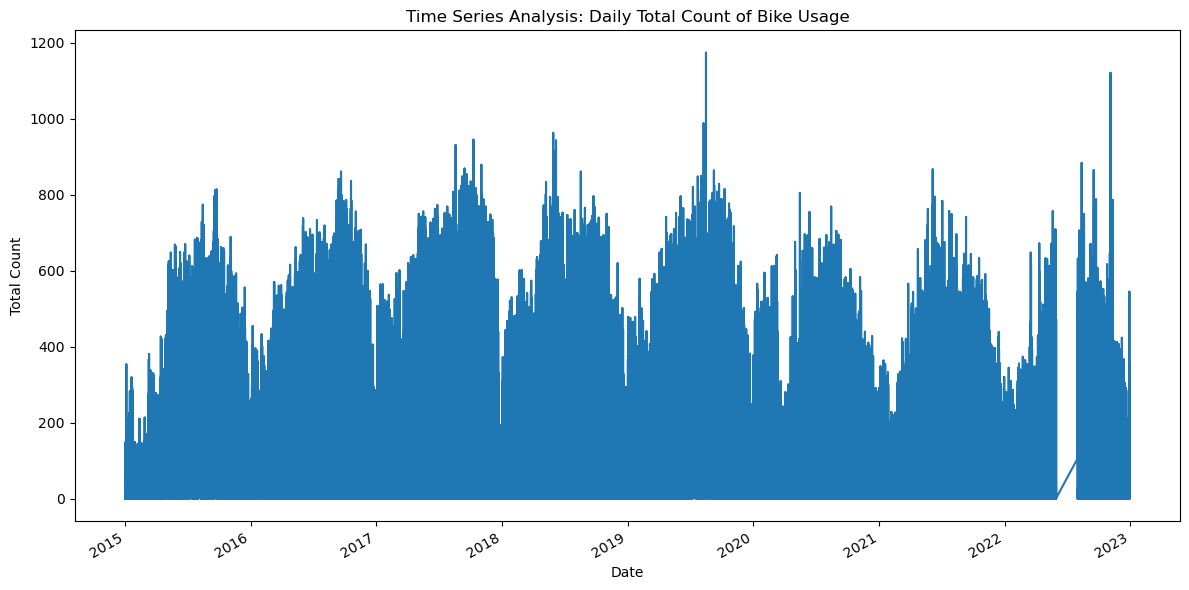

In [82]:
#time_series_pd = time_series_df.toPandas(): This line converts the PySpark dataframe time_series_df to a pandas dataframe time_series_pd.

#time_series_pd['Date'] = pd.to_datetime(time_series_pd['Date']): This line converts the 'Date' column in your dataframe to a datetime object. This is important for time series analysis, as it ensures that pandas recognizes the 'Date' column as a date/time and not just a string or other type of object.

#time_series_pd.set_index('Date', inplace=True): This sets the 'Date' column as the index of your dataframe. This is standard in time series analysis, where the index of the dataframe often represents the time component.

#fig, ax = plt.subplots(figsize=(12, 6)): This creates a new matplotlib figure with a single subplot. The figsize parameter sets the width and height of the figure in inches.

#time_series_pd['Total_Count'].plot(ax=ax): This plots the 'Total_Count' column on your subplot. The line is automatically labeled with the column name ('Total_Count').

#ax.set_ylabel('Total Count'): This sets the y-axis label to 'Total Count'.

#ax.set_title('Time Series Analysis: Daily Total Count of Bike Usage'): This sets the title of the plot.

#plt.show(): This displays the plot. It's the last line in the script, indicating that everything else has been setup and the plot should now be shown.

time_series_pd = time_series_df.toPandas()
time_series_pd['Date'] = pd.to_datetime(time_series_pd['Date'])
time_series_pd.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
time_series_pd['Total_Count'].plot(ax=ax)
ax.set_ylabel('Total Count')
ax.set_title('Time Series Analysis: Daily Total Count of Bike Usage')
plt.show()


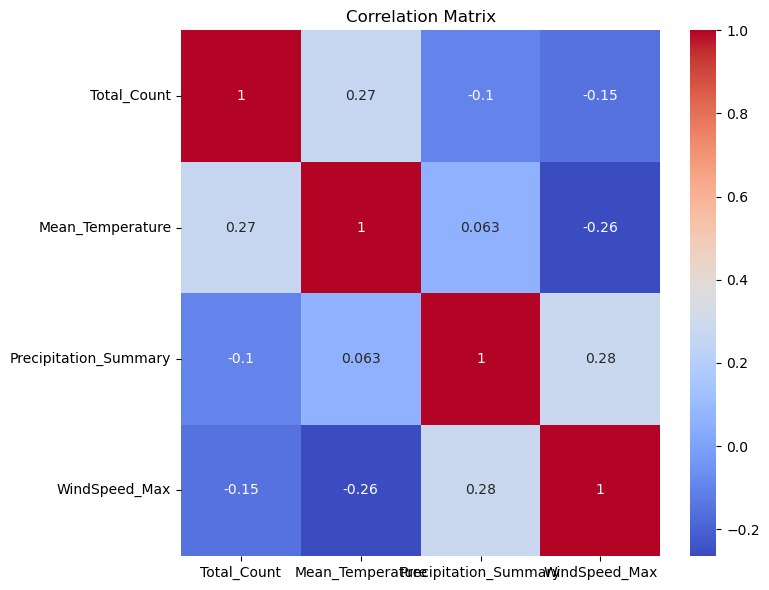

In [83]:
#correlation_df = df1.select("Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max"): This line selects the specified columns ("Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max") from the DataFrame df1 and assigns the resulting subset to correlation_df.

#correlation_pd = correlation_df.toPandas().corr(): This line converts the correlation_df DataFrame to a Pandas DataFrame using the toPandas() method and calculates the correlation matrix using the corr() function. The resulting correlation matrix is stored in the correlation_pd variable.

#plt.figure(figsize=(8, 6)): This line creates a figure with a specified size of 8 inches (width) by 6 inches (height).

#sns.heatmap(correlation_pd, annot=True, cmap='coolwarm'): This line creates a heatmap plot using the sns.heatmap() function from the seaborn library. The correlation_pd DataFrame is passed as the data, annot=True adds annotations to the plot indicating the correlation values, and cmap='coolwarm' sets the color map for the heatmap.

#plt.title('Correlation Matrix'): This line sets the title of the plot to "Correlation Matrix".

correlation_df = df1.select("Total_Count", "Mean_Temperature", "Precipitation_Summary", "WindSpeed_Max")
correlation_pd = correlation_df.toPandas().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_pd, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


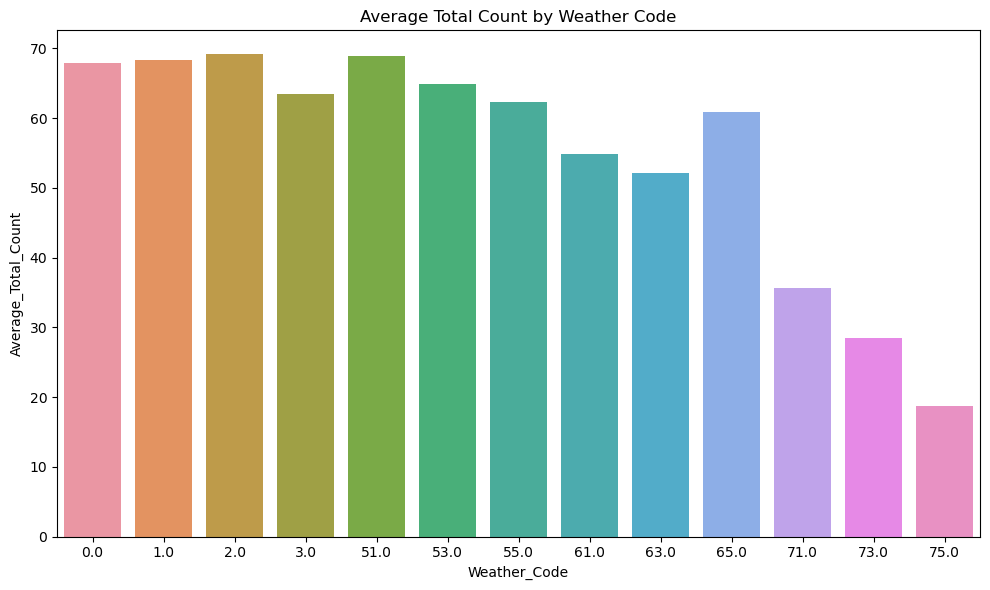

In [85]:
#weather_categories_pd = weather_df.toPandas(): This line converts the weather_df DataFrame to a Pandas DataFrame using the toPandas() method and assigns it to the variable weather_categories_pd. This step is necessary because seaborn works directly with Pandas DataFrames.

#plt.figure(figsize=(10, 6)): This line creates a figure with a specified size of 10 inches (width) by 6 inches (height).

#sns.barplot(x='Weather_Code', y='Average_Total_Count', data=weather_categories_pd): This line creates a bar plot using the sns.barplot() function from the seaborn library. The x parameter specifies the column name ('Weather_Code') to be plotted on the x-axis, the y parameter specifies the column name ('Average_Total_Count') to be plotted on the y-axis, and the data parameter specifies the DataFrame (weather_categories_pd) containing the data to be plotted.

#plt.title('Average Total Count by Weather Code'): This line sets the title of the plot to "Average Total Count by Weather Code".
weather_categories_pd = weather_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Weather_Code', y='Average_Total_Count', data=weather_categories_pd)
plt.title('Average Total Count by Weather Code')
plt.show()


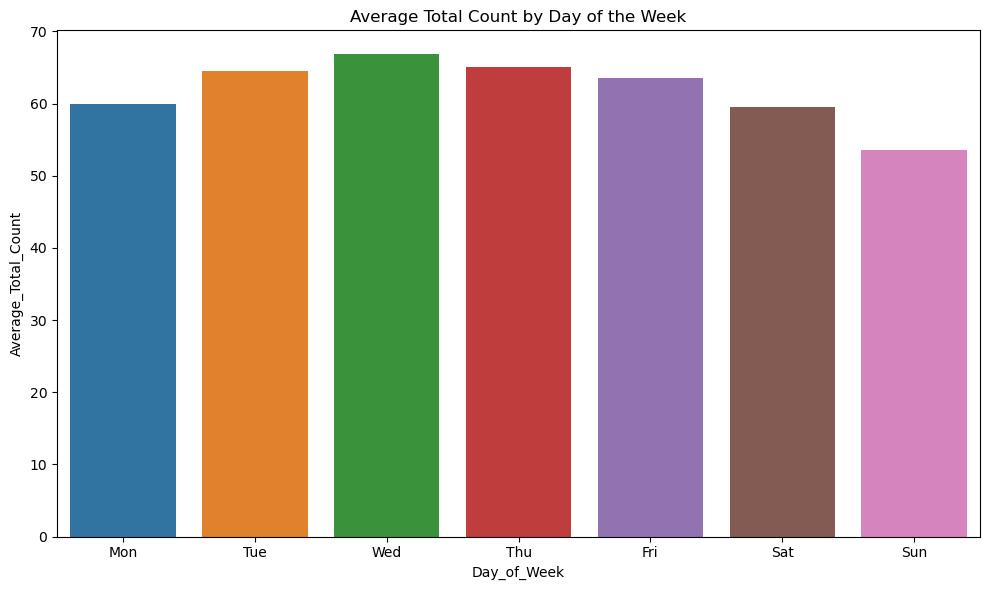

In [86]:
#day_of_week_pd = day_of_week_df.toPandas(): This line converts the day_of_week_df DataFrame to a Pandas DataFrame using the toPandas() method and assigns it to the variable day_of_week_pd. This step is necessary because seaborn works directly with Pandas DataFrames.

#plt.figure(figsize=(10, 6)): This line creates a figure with a specified size of 10 inches (width) by 6 inches (height).

#sns.barplot(x='Day_of_Week', y='Average_Total_Count', data=day_of_week_pd, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']): This line creates a bar plot using the sns.barplot() function from the seaborn library. The x parameter specifies the column name ('Day_of_Week') to be plotted on the x-axis, the y parameter specifies the column name ('Average_Total_Count') to be plotted on the y-axis, the data parameter specifies the DataFrame (day_of_week_pd) containing the data to be plotted, and the order parameter specifies the order of the x-axis categories as ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'].

#plt.title('Average Total Count by Day of the Week'): This line sets the title of the plot to "Average Total Count by Day of the Week".
day_of_week_pd = day_of_week_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='Average_Total_Count', data=day_of_week_pd, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average Total Count by Day of the Week')
plt.show()


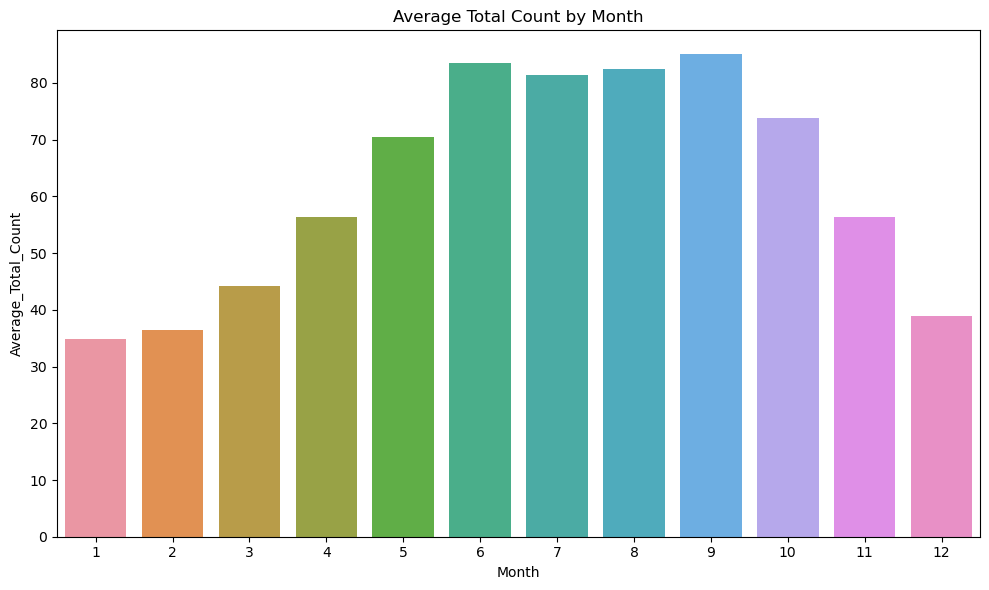

In [87]:
#month_pd = seasonal_df.toPandas(): This line converts the seasonal_df DataFrame to a Pandas DataFrame using the toPandas() method and assigns it to the variable month_pd. This step is necessary because seaborn works directly with Pandas DataFrames.

#plt.figure(figsize=(10, 6)): This line creates a figure with a specified size of 10 inches (width) by 6 inches (height).

#sns.barplot(x='Month', y='Average_Total_Count', data=month_pd): This line creates a bar plot using the sns.barplot() function from the seaborn library. The x parameter specifies the column name ('Month') to be plotted on the x-axis, the y parameter specifies the column name ('Average_Total_Count') to be plotted on the y-axis, and the data parameter specifies the DataFrame (month_pd) containing the data to be plotted.

#plt.title('Average Total Count by Month'): This line sets the title of the plot to "Average Total Count by Month".
month_pd = seasonal_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Average_Total_Count', data=month_pd)
plt.title('Average Total Count by Month')
plt.show()


# Model Building

After EDA now its time to build our final models.
* We used 3 ML Regression Models ie Linear Regressor, Generalized Liner Regressor and Gradient Boosted Tree.
* To format data and train and test the models we create 2 pipelines
* One pipeline is fixed only for GBT as it does not need any encoding for the categorical feature (Station name)
* GBT was also giving better results without doing MinMaxScaling of data.

In [8]:
#Split Input Data into Test and Train set for HyperParameter tuning
data_train , data_test = df1.randomSplit([0.8,0.2], seed = 123)

In [9]:
def get_model_pipeline(model_name):
    #This function builds model pipeline based on model name
    #String indexer is used to convert station names into unique integer values 
    string_indexer = MF.StringIndexer(inputCol="Station", outputCol="Station_idx")
    station_col = "Station_idx"
    
    # If model is not Gradient Boosted tree, we convert station name into one hot encoded format
    if model_name != "GBT":
        oneHot = MF.OneHotEncoder(inputCol="Station_idx", outputCol="Station_OHE")
        station_col = "Station_OHE"
    
    # We take all useful features and convert them into feature vectors for ML algorithm
    assembler = MF.VectorAssembler(
                    inputCols = [station_col,"Mean_Temperature","Precipitation_Summary",
                    "Rain_Summary","Snow_Summary", "WindSpeed_Max", "Year", "Weather_Code"],
                    outputCol = "Input_Attributes"
                )
    
    # We use Min Max scalar to normalize the data
    continuous_scaler = MF.MinMaxScaler( 
                    inputCol="Input_Attributes",
                    outputCol="Input_Attributes_Scaled",
                )
    
    # We generate model based on requested model_name (The HyperParameters were selected after tuning)
    if model_name == "LR":
        model = LinearRegression(labelCol = "Total_Count",featuresCol = 'Input_Attributes_Scaled',
                                loss="squaredError", fitIntercept=False, elasticNetParam=0.8)
    elif model_name == "GLR":
        model = GeneralizedLinearRegression(labelCol = "Total_Count", featuresCol = 'Input_Attributes_Scaled',
                                            family="gaussian", link="identity", maxIter=25, regParam=0.1)
    else:
        model = GBTRegressor(featuresCol="Input_Attributes", labelCol="Total_Count",
                             maxBins=2000, lossType="squared", maxDepth=5, stepSize=0.5)
    
    # Pipeline for GBT does not include OneHotEncoder and MinMaxScalar 
    if model_name != "GBT":
        pipeline = Pipeline(stages=[string_indexer, oneHot, assembler, continuous_scaler, model])
    else:
        pipeline = Pipeline(stages=[string_indexer, assembler, model])
    return pipeline, model

## HyperParameter Tuning For Gradient Boosted Tree.

GBT Model was tuned for the following parameters.
* LossType = Criteria of loss function
* MaxDepth = Maximum depth of each tree
* MaxBins = Max number of bins for discretizing continuous features
* stepSize = Learning rate

Best Parameter selected were:
* lossType: squared,
* maxBins: 2000,
* maxDepth: 5,
* stepSize: 0.5

In [10]:

Model_pipeline, gbt = get_model_pipeline("GBT")

gbparamGrid = (ParamGridBuilder()
             .addGrid(gbt.lossType, ["squared", "absolute"])
             .addGrid(gbt.maxDepth, [3, 5])
             .addGrid(gbt.maxBins, [2000])
             .addGrid(gbt.stepSize, [0.1, 0.5])
             .build())

evaluator = RegressionEvaluator(labelCol = 'Total_Count', metricName='r2')

cv = CrossValidator(
    estimator=Model_pipeline,
    estimatorParamMaps=gbparamGrid,
    evaluator=evaluator,
    numFolds=2,
    seed=13,
)

cv_model = cv.fit(data_train)

final_model = cv_model.bestModel
print ('Best Param (regParam): ', (final_model.stages[-1]._java_obj.paramMap()))
print ('Best Param (LossType): ', (final_model.stages[-1]._java_obj.getLossType()))
print ('Best Param (StepSize): ', (final_model.stages[-1]._java_obj.getStepSize()))
pred = final_model.transform(data_test)

evalu = RegressionEvaluator(labelCol = 'Total_Count')
rmse = evalu.evaluate(pred, {evalu.metricName:'rmse'})
r2 =evalu.evaluate(pred,{evalu.metricName:'r2'})

print("RMSE: %.2f" %rmse)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2)

23/05/12 16:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB
23/05/12 16:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1054.5 KiB
23/05/12 16:32:36 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB
23/05/12 16:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1057.5 KiB
23/05/12 16:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
23/05/12 16:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1028.4 KiB
23/05/12 16:34:41 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
23/05/12 16:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
23/05/12 16:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1046.8 KiB
23/05/12 16:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
23/05/12 16:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1091.5 KiB
23/05/12 16:34:52 WAR

Best Param (regParam):  {
	GBTRegressor_1f49d0c5999a-featuresCol: Input_Attributes,
	GBTRegressor_1f49d0c5999a-labelCol: Total_Count,
	GBTRegressor_1f49d0c5999a-lossType: squared,
	GBTRegressor_1f49d0c5999a-maxBins: 2000,
	GBTRegressor_1f49d0c5999a-maxDepth: 5,
	GBTRegressor_1f49d0c5999a-stepSize: 0.5
}
Best Param (LossType):  squared
Best Param (StepSize):  0.5


RMSE: 28.39
R2: 0.84


## HyperParameter Tuning For Generalized Linear Regressor.

GLR Model was tuned for the following parameters.
* regParam = Regularization parameter
* family = Describes the error distribution to be used in the model
* link =  Function which provides the relationship between the linear predictor and the mean of the distribution function. 

Best Parameter selected were:
* regParam =  0.1
* Family = gaussian
* Link:  identity

In [51]:
evaluator = RegressionEvaluator(labelCol = 'Total_Count', metricName='r2')

Model_pipeline, glr = get_model_pipeline("GLR")

glr_grid = (ParamGridBuilder()
             .addGrid(glr.regParam, [0.1, 0.5])
             .addGrid(glr.family, ["gamma", "gaussian"])
             .addGrid(glr.link, ["log", "identity"])
             .build())

cv = CrossValidator(
    estimator=Model_pipeline,
    estimatorParamMaps=glr_grid,
    evaluator=evaluator,
    numFolds=3,
    seed=13,
)
   
cv_model = cv.fit(data_train)

final_model = cv_model.bestModel

print ('Best Param (regParam): ', final_model.stages[-1]._java_obj.getRegParam())
print ('Best Param (MaxIter): ', final_model.stages[-1]._java_obj.getMaxIter())
print ('Best Param (Family): ', final_model.stages[-1].getFamily())
print ('Best Param (Link): ', final_model.stages[-1].getLink())

pred = final_model.transform(data_test)

print("RMSE: %.2f" %rmse)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2)

Best Param (regParam):  0.1
Best Param (MaxIter):  25
Best Param (Family):  gaussian
Best Param (Link):  identity
RMSE: 28.10
R2: 0.85


## HyperParameter Tuning For Linear Regressor.

LR Model was tuned for the following parameters.
* loss = The loss function to be optimized
* fitIntercept = Whether to fit an intercept term.
* elasticNetParam = The ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.

Best Parameter selected were:
* loss = squaredError
* fitIntercept = False
* elasticNetParam = 0.8

In [53]:
Model_pipeline, l_regressor = get_model_pipeline("LR")

evaluator = RegressionEvaluator(labelCol = 'Total_Count', metricName='r2')

paramGrid = ParamGridBuilder()\
    .addGrid(l_regressor.loss, ["squaredError"]) \
    .addGrid(l_regressor.fitIntercept, [False, True])\
    .addGrid(l_regressor.elasticNetParam, [0.2, 0.5, 0.8])\
    .build()


cv = CrossValidator(estimator=Model_pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=3,
                           seed=13,
                           collectSubModels=True,
                        )

cv_model = cv.fit(data_train)

final_model = cv_model.bestModel

print ('Best Param (ElasticNetParam): ', final_model.stages[-1]._java_obj.getElasticNetParam())
print ('Best Param (FitIntercept): ', final_model.stages[-1]._java_obj.getFitIntercept())
print ('Best Param (Loss): ', final_model.stages[-1].getLoss())


pred = final_model.transform(data_test)

eval = RegressionEvaluator(labelCol = 'Total_Count')
rmse = eval.evaluate(pred, {eval.metricName:'rmse'})
r2 =eval.evaluate(pred,{eval.metricName:'r2'})

print("RMSE: %.2f" %rmse)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2)

23/05/09 09:35:01 WARN CacheManager: Asked to cache already cached data.
23/05/09 09:35:01 WARN CacheManager: Asked to cache already cached data.
23/05/09 09:35:05 WARN Instrumentation: [a19efc72] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:35:44 WARN Instrumentation: [11d15de9] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:36:20 WARN Instrumentation: [ce93530b] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:36:56 WARN Instrumentation: [f2763a2d] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:37:32 WARN Instrumentation: [6d4655b9] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:38:08 WARN Instrumentation: [f251367d] regParam is zero, which might cause numerical instability and overfitting.
23/05/09 09:38:48 WARN Instrumentation: [02a5d3eb] regParam is zero, which might cause numerical i

Best Param (ElasticNetParam):  0.8
Best Param (FitIntercept):  False
Best Param (Loss):  squaredError


RMSE: 37.58
R2: 0.72


# Scale Up, Scale Out

Scale Up:
* To compare the impact of increased computation on model performance, a scaling up experiment was conducted using fixed data (100%) and a consistent node count of 2 nodes.
* Three different configurations were considered: N1-4-2, N1-8-4, and N2-8-8. (Series - Masters CPU - Workers CPU)
* The experiment aimed to assess the performance of three models: LR (Linear Regression), GLR (Generalized Linear Regression), and GBT (Gradient Boosting Trees) by analyzing their RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), R² (R-squared) scores, and run time. 

1. N1-4-2 Configuration: 

   - This configuration represents a model with a single layer (N1) consisting of 4 nodes, followed by another layer (N2) with 2 nodes. 

   - The models with this configuration were evaluated for LR, GLR, and GBT. 

   - The performance metrics including RMSE, MAE, R², and run time were recorded for each model. 

 

2. N1-8-4 Configuration: 

   - This configuration denotes a model with a single layer (N1) comprising 8 nodes, followed by another layer (N2) consisting of 4 nodes. 

   - The LR, GLR, and GBT models were assessed using this configuration. 

   - The metrics of interest, namely RMSE, MAE, R², and run time, were measured for each model. 

 

3. N2-8-8 Configuration: 

   - This configuration signifies a model with two layers (N2) having 8 nodes each. 

   - Similar to the previous configurations, LR, GLR, and GBT models were evaluated using this setup. 

   - The performance metrics, including RMSE, MAE, R², and run time, were collected for each model. 

 

By generating a comprehensive report based on the obtained results, the impact of increased computation on model performance can be analyzed. The report will provide insights into how adjusting the configuration affects the accuracy (RMSE, MAE, R²) of each model as well as the time (run time) required to train and make predictions. This analysis will facilitate understanding the trade-offs associated with increased computational resources and help determine the optimal configuration for achieving the desired performance. 

___

ScaleOut: 

To assess the impact of increased nodes on model performance, a scaling out experiment was conducted using a fixed compute configuration of N1-4-2 and a local setup. The experiment aimed to analyze the performance of three models: LR (Linear Regression), GLR (Generalized Linear Regression), and GBT (Gradient Boosting Trees) by varying the number of nodes. The number of nodes considered were 2, 4, 6, 7, and a local node. 

 

1. Fixed Compute Configuration - N1-4-2: 

   - This configuration refers to a model with a single layer (N1) consisting of 4 nodes, followed by another layer (N2) with 2 nodes. 

   - The models were kept constant across all nodes for this experiment. 

   - The subsequent analysis focuses on the impact of increasing the number of nodes while keeping the compute configuration fixed. 

 

2. Node Count: 

   - The number of nodes used for scaling out the experiment was varied. The different node counts considered were 2, 4, 6, 7, and a local node. 

   - Increasing the number of nodes allows for parallel processing and can potentially lead to improved performance. 

 

3. Data Range and Percentage: 

   - Multiple ranges of data were considered to evaluate the model performance at different levels of data availability. 

   - The ranges and their corresponding percentages of data are as follows: 

     - 2022: 18.8% of the total available data. 

     - 2020-2022: 54% of the total available data. 

     - 2018-2022: 77.36% of the total available data. 

     - 2016-2022: 94.44% of the total available data. 

     - 2015-2022: 100% of the total available data. 

 

4. Model Evaluation: 

   - LR, GLR, and GBT models were assessed using the fixed compute configuration (N1-4-2) and varying node counts. 

   - The performance metrics of interest, including RMSE, MAE, R², and run time, were recorded for each model. 
   
By generating a comprehensive report based on the obtained results, the impact of increased nodes on model performance can be analyzed. The report will provide insights into how scaling out, by increasing the number of nodes, affects the accuracy (RMSE, MAE, R²) of each model, as well as the time (run time) required for training and making predictions. This analysis will help determine the optimal number of nodes required to achieve the desired performance level and scalability in the model. 

In [9]:
def upload_csv_to_bucket(local_path):
    #This functions is to upload file from cluster to GCP storage bucket
    blob_path = 'final_dataset/report/scale_up/' + local_path
    blob = bucket.blob(blob_path)
    blob.upload_from_filename("/" + local_path)

def create_csv():
    #This function generates a blank report csv
    csv_file = f"report_csv_{random.randint(1,20000)}.csv"
    field = ["Model", "Nodes", "Config", "Percent_Data", "Years", "Run_Time", "RMSE", "MAE", "R2"]
    with open(csv_file, 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(field)
    return csv_file

def append_csv(csv_file, data):
    #This function appends information to already created blank CSV
    with open(csv_file, 'a') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerows(data)

def get_years_list(i):
    #This function returns list of years based on requested index
    l = [2022,2021,2020,2019,2018,2017,2016,2015]
    if i == 0:
        return [2022]
    else:
        return l[:i]

* The below loop is currently configured to generate scale up reports
* It can be modified slightly for generating scale out report as well
* The report is generated locally first on master nodes harddisk
* Once the report is completed, it is uploaded to GCP's Cloud storage's bucket

In [10]:
#This is where we loop over the various portion of dataset and also all algorithms and generate a report

nodes = 2 #int(input("Current Nodes")) # Fixed nodes for Scale up, User input for scale out
config = input("Current Config") # Current configuration - User imput for scale up, Fixed for scale out
total_data_count = df1.count()
csv_file = create_csv()

for i in [9]:#[1,3,5,7,9]: # Number of years of data to be considered
    data_years = get_years_list(i) # Getting list of years
    print("For ", data_years)
    cur_df = df1.filter(df1.Year.isin(data_years)) # Filtering down the dataset to contain only required number of years
    
    cur_count = cur_df.count()
    data_percent = (cur_count/total_data_count) * 100 # calculating total percent of data currently being used
    
    cur_train , cur_test = cur_df.randomSplit([0.8,0.2], seed = 123) # Spliiting data into 80% train and 20% test data.
    
    report_info = []
    
    for model in ["LR", "GLR", "GBT"]: # Looping over all there models
        print("Models ", model)
        start_time = time.time()
        model_pipeline, _ = get_model_pipeline(model)
        fitted_model = model_pipeline.fit(cur_train) # Training current Model
        pred = fitted_model.transform(cur_test) # Using model to make prediction on test data
        
        # Evaluating model performance
        evaluator = RegressionEvaluator(labelCol = 'Total_Count')
        rmse = evaluator.evaluate(pred, {evaluator.metricName:'rmse'})
        mae = evaluator.evaluate(pred, {evaluator.metricName:'mae'})
        r2 = evaluator.evaluate(pred,{evaluator.metricName:'r2'})
        
        total_time = time.time() - start_time # Measing total time it took to run the model
        
        report = [model, nodes, config, data_percent, 
                  f"{data_years[0]} - {data_years[-1]}" if len(data_years) > 1 else data_years[0],
                  total_time, rmse, mae, r2] # Storing models information
        print(report)
        report_info.append(report)
    append_csv(csv_file, report_info) #Writing report
    
upload_csv_to_bucket(csv_file)      # Uploading report to GCP Storage bucket

Current ConfigN2-8-N1-8


For  [2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015]


Models  LR


23/05/09 23:07:15 WARN Instrumentation: [8bd90795] regParam is zero, which might cause numerical instability and overfitting.


['LR', 2, 'N2-8-N1-8', 100.0, '2022 - 2015', 119.74946475028992, 37.6854777013322, 24.454609539935188, 0.7210914186052493]
Models  GLR


['GLR', 2, 'N2-8-N1-8', 100.0, '2022 - 2015', 77.72209453582764, 37.68725771716557, 24.44604859522081, 0.7210650703434767]
Models  GBT


23/05/09 23:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
23/05/09 23:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
23/05/09 23:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1030.0 KiB
23/05/09 23:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1036.1 KiB
23/05/09 23:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1078.1 KiB
23/05/09 23:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1100.6 KiB
23/05/09 23:10:30 WARN DAGScheduler: Broadcasting large task binary with size 1147.4 KiB
23/05/09 23:10:30 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB
23/05/09 23:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
23/05/09 23:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1181.6 KiB
23/05/09 23:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1223.0 KiB
23/05/09 23:10:32 WAR

['GBT', 2, 'N2-8-N1-8', 100.0, '2022 - 2015', 78.51251721382141, 28.522882765959245, 16.77854046719697, 0.8402280039090783]


# Plotting Results

In [25]:
# Reading all Report files from GCP Cloud storage and creating a pandas DF with it.
all_pdfs = []
for i in storage_files:
    if "scale_out" in i:
        pdf = pd.read_csv(BUCKET_PATH + i)
        all_pdfs.append(pdf)

report_pdf = pd.concat(all_pdfs, axis=0, ignore_index=True)


In [26]:
report_pdf["Data_Used"] = report_pdf.apply(lambda row: str(row["Years"]) + " (%s%%)" % round(row["Percent_Data"],2), axis=1)

In [27]:
report_pdf

,Model,Nodes,Config,Percent_Data,Years,Run_Time,RMSE,MAE,R2,Data_Used
0,LR,7,N1-4-2,18.876873,2022,171.909784,31.329627,19.983183,0.777018,2022 (18.88%)
1,GLR,7,N1-4-2,18.876873,2022,90.295481,31.330602,19.972252,0.777004,2022 (18.88%)
2,GBT,7,N1-4-2,18.876873,2022,109.859121,23.344923,13.085052,0.876193,2022 (18.88%)
3,LR,7,N1-4-2,54.189163,2022 - 2020,107.511337,34.107566,21.804052,0.743204,2022 - 2020 (54.19%)
4,GLR,7,N1-4-2,54.189163,2022 - 2020,81.234011,34.108796,21.788145,0.743185,2022 - 2020 (54.19%)
...,...,...,...,...,...,...,...,...,...,...
73,LR,Local,Local,77.361697,2022 - 2018,340.339600,36.598479,23.331546,0.730118,2022 - 2018 (77.36%)
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan (nan%)
75,GLR,Local,Local,77.361697,2022 - 2018,263.845169,36.599483,23.320108,0.730104,2022 - 2018 (77.36%)
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan (nan%)


In [39]:
def get_plot(plot_type, data):
    # A Function to plot the report as matplotlib line graph
    plt.rcParams["figure.figsize"] = [9.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    plt.xticks(rotation = 0)
    
    for node in data.Nodes.unique():
        plt.plot(data[data.Nodes == node].Data_Used.unique(), data[data.Nodes == node][plot_type], linestyle='--', marker='o')

    plt.legend([f"Node = {a}" for a in data.Nodes.unique()])
    plt.xlabel("Data Used")
    if plot_type == "Run_Time":
        plt.ylabel("Time Taken (in Sec)")
        plt.title("Data vs Time (Per Node)")
    else:
        plt.ylabel("R-Squared Score")
        plt.title("Data vs R-Squared Score (Per Node)")
    plt.show()

## Scale Up, Scale Out - Linear Regression



* The expected result was observed where the highest runtime was recorded on the local machine, while the lowest runtime was achieved on nodes 6 and 7. This indicates that the parallel processing capability of distributed nodes effectively reduces the overall runtime. 

* However, there was an unexpected increase in runtime on node 2 after 94% of the data was selected, which resulted in a machine failure. This suggests a potential performance bottleneck or resource limitation on node 2 when handling large data volumes. Further investigation and optimization may be necessary to address this issue. 

* The R2 value gradually decreased as the amount of data increased. This observation implies that as more data is included in the model, the predictive power of the model decreases slightly, possibly due to increased complexity or noise in the additional data. 

* Despite the gradual decrease in overall R2 value, the R2 value at each selected node remained relatively constant for all the selected data amounts. This consistency suggests that the performance of the individual nodes, in terms of capturing the relationship between predictors and the target variable, remained stable regardless of the data volume used. 

In [40]:
lr_report = report_pdf[report_pdf.Model == "LR"]

In [41]:
lr_report

,Model,Nodes,Config,Percent_Data,Years,Run_Time,RMSE,MAE,R2,Data_Used
0,LR,7,N1-4-2,18.876873,2022,171.909784,31.329627,19.983183,0.777018,2022 (18.88%)
3,LR,7,N1-4-2,54.189163,2022 - 2020,107.511337,34.107566,21.804052,0.743204,2022 - 2020 (54.19%)
6,LR,7,N1-4-2,77.361697,2022 - 2018,112.399890,36.443346,23.270994,0.729893,2022 - 2018 (77.36%)
9,LR,7,N1-4-2,94.435889,2022 - 2016,115.288735,37.323668,24.055676,0.725083,2022 - 2016 (94.44%)
12,LR,7,N1-4-2,100.000000,2022 - 2015,116.171745,37.722341,24.471480,0.719736,2022 - 2015 (100.0%)
15,LR,4,N1-4-2,18.876873,2022,202.032192,31.519058,20.032943,0.772649,2022 (18.88%)
18,LR,4,N1-4-2,54.189163,2022 - 2020,155.910407,34.151839,21.855707,0.744294,2022 - 2020 (54.19%)
21,LR,4,N1-4-2,77.361697,2022 - 2018,164.498727,36.598479,23.331546,0.730118,2022 - 2018 (77.36%)
24,LR,4,N1-4-2,94.435889,2022 - 2016,162.979282,37.359620,24.089180,0.726168,2022 - 2016 (94.44%)
27,LR,4,N1-4-2,100.000000,2022 - 2015,169.867927,37.792788,24.510413,0.720842,2022 - 2015 (100.0%)


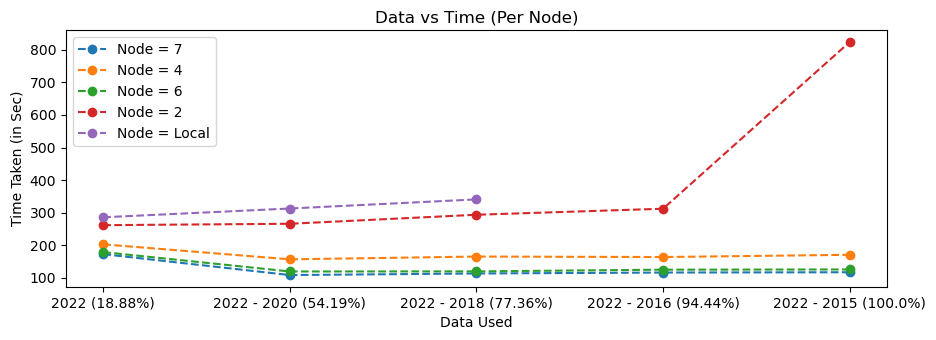

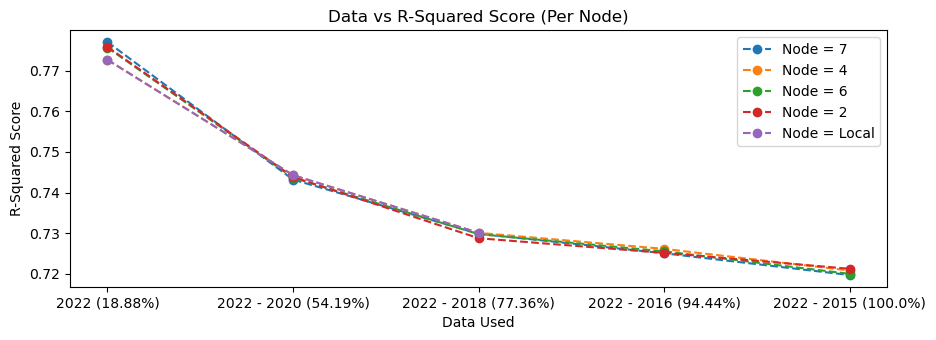

In [42]:
get_plot("Run_Time", lr_report)
get_plot("R2", lr_report)

## Scale Up, Scale Out - Generalized Linear Regression

* The GLR (Generalized Linear Regression) model exhibited a notable difference in run time between different nodes compared to the LR (Linear Regression) and GBT (Gradient Boosting Trees) models. This disparity suggests that the GLR algorithm is more computationally intensive and time-consuming than the other two models. 

* Unlike LR and GBT, the GLR algorithm involves solving optimization problems iteratively, which adds to its complexity. To parallelize the GLR model and improve its efficiency, the dataset needs to be partitioned into smaller subsets, allowing each subset to be processed independently on different nodes. This parallel processing approach can help distribute the computational load and expedite the runtime of the GLR model. 

* The need to partition the data into smaller subsets and process them separately on different nodes is crucial for achieving parallelization in the GLR model. By dividing the dataset, each node can independently work on its assigned subset, thereby increasing the computational efficiency and potentially reducing the overall run time of the GLR model. 

In [43]:
glr_report = report_pdf[report_pdf.Model == "GLR"]

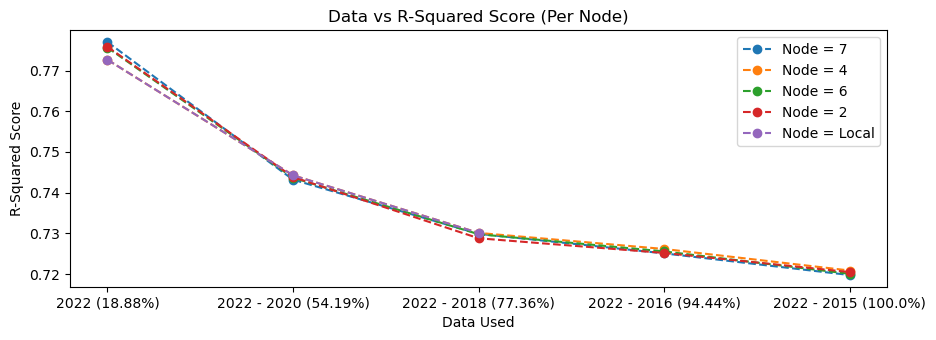

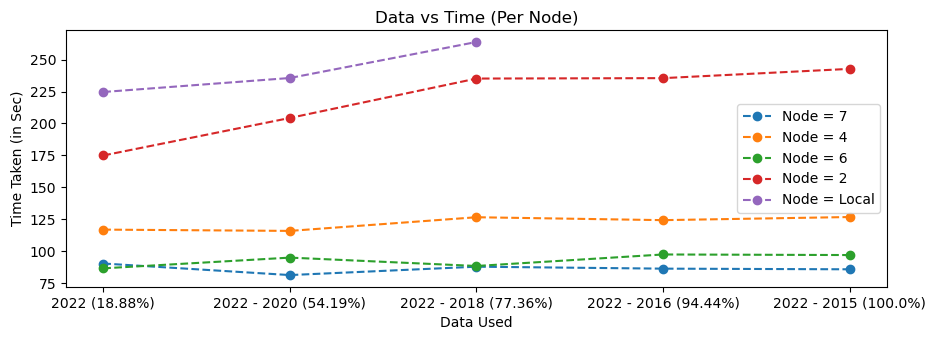

In [44]:
get_plot("R2", glr_report)
get_plot("Run_Time", glr_report)

## Scale Up, Scale Out - Gradient Boosted Tree Regressor

* The disparity in the R2 scores observed in GBT (Gradient Boosting Trees) models for smaller amounts of data could be attributed to overfitting. With less data, individual trees in the GBT model can become excessively specific, capturing noise and leading to lower generalization ability. As the amount of data increases, the model becomes less prone to overfitting, resulting in reduced variance and higher R2 scores. 

 

* Variations in the data distribution or the random seed used in the GBT algorithm can cause differences in the R2 scores across nodes. However, this effect diminishes as the amount of data increases, as the larger dataset tends to mitigate the impact of initial conditions, resulting in more consistent R2 scores across nodes. 

 

* Another spike in runtime was encountered at the 94.44% data mark when using 2 nodes, which likely indicates a potential bottleneck or resource limitation. Further investigation is needed to understand the cause of this runtime spike and address any potential issues that may affect the performance and scalability of the system. 

In [47]:
gbt_report = report_pdf[report_pdf.Model == "GBT"]

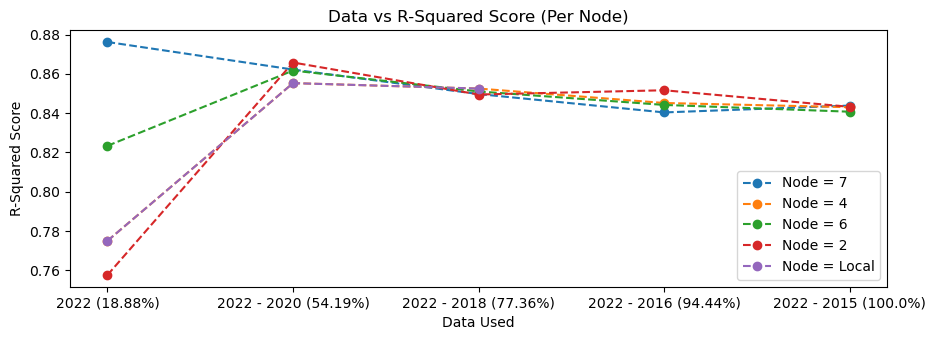

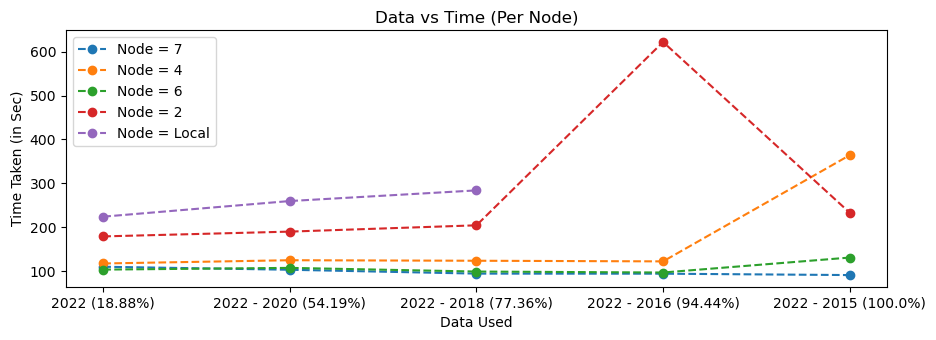

In [48]:
get_plot("R2", gbt_report)
get_plot("Run_Time", gbt_report)

## Comparing Each Model

/tmp/ipykernel_8829/562043599.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_report['Nodes'] = full_data_report['Nodes'].astype(str)


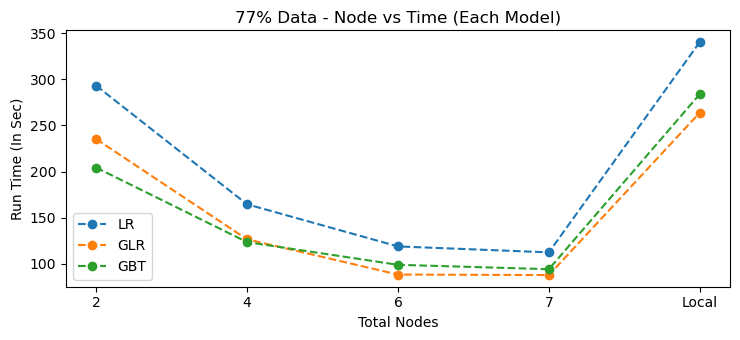

In [57]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

full_data_report = report_pdf[report_pdf.Years == "2022 - 2018"]
full_data_report['Nodes'] = full_data_report['Nodes'].astype(str)
full_data_report = full_data_report.sort_values(by=['Nodes'])

for model in full_data_report.Model.unique():
    plt.plot(full_data_report.Nodes.unique(), full_data_report[full_data_report.Model == model].Run_Time, linestyle='--', marker='o')

plt.legend(full_data_report.Model.unique())
plt.xlabel("Total Nodes")
plt.ylabel("Run Time (In Sec)")
plt.title("77% Data - Node vs Time (Each Model)")
plt.show()

/tmp/ipykernel_8829/1749160861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_report['Nodes'] = full_data_report['Nodes'].astype(str)


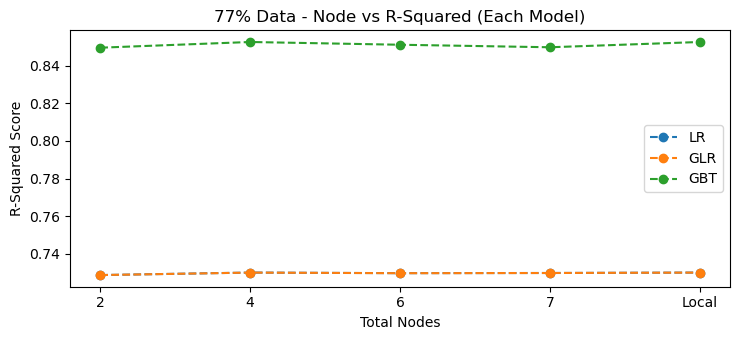

In [58]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

full_data_report = report_pdf[report_pdf.Years == "2022 - 2018"]
full_data_report['Nodes'] = full_data_report['Nodes'].astype(str)
full_data_report = full_data_report.sort_values(by=['Nodes'])

for model in full_data_report.Model.unique():
    plt.plot(full_data_report.Nodes.unique(), full_data_report[full_data_report.Model == model].R2, linestyle='--', marker='o')

plt.legend(full_data_report.Model.unique())
plt.xlabel("Total Nodes")
plt.ylabel("R-Squared Score")
plt.title("77% Data - Node vs R-Squared (Each Model)")
plt.show()

## Scale Up - Better computation - Same Node Size

In [59]:
all_pdfs = []
for i in storage_files:
    if "scale_up" in i:
        pdf = pd.read_csv(BUCKET_PATH + i)
        all_pdfs.append(pdf)

scale_up_pdf = pd.concat(all_pdfs, axis=0, ignore_index=True)

Scale Up Analysis:

* The table provided presents the performance metrics of three different models: LR (Linear Regression), GLR (Generalized Linear Regression), and GBT (Gradient Boosting Trees). These models were evaluated based on various configurations, and their performance was measured using metrics such as run time, RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R² (R-squared) scores. 

*  Among the three models, GBT demonstrated superior performance compared to LR and GLR. GBT achieved the lowest RMSE and MAE scores, indicating that it had the smallest average prediction errors compared to the other models. Additionally, GBT obtained the highest R² score, which signifies that it explained the highest proportion of the variance in the observed data, indicating a better fit to the actual values. 

*  The N2-8-N1-8 configuration, which represents the specific parameter settings of the models, resulted in the lowest run time for all three models. This indicates that this configuration required the least amount of time to train and make predictions. On the other hand, the N1-4-2 configuration had the highest run time among all the configurations tested. This information provides insights into the computational efficiency of the models under different parameter settings. 

*  One notable observation is that using higher computational power can help reduce the operation cost. When models have lower run times, they require fewer computational resources, resulting in reduced operational expenses. This suggests that investing in more powerful computing infrastructure or optimizing the algorithms can lead to cost savings in the long run. 

 

In [60]:
scale_up_pdf

,Model,Nodes,Config,Percent_Data,Years,Run_Time,RMSE,MAE,R2
0,LR,2,N1-8-4,100.0,2022 - 2015,219.125747,37.792788,24.510413,0.720842
1,GLR,2,N1-8-4,100.0,2022 - 2015,146.435559,37.791384,24.500009,0.720863
2,GBT,2,N1-8-4,100.0,2022 - 2015,132.135890,28.340158,16.860005,0.843023
3,LR,2,N2-8-N1-8,100.0,2022 - 2015,119.749465,37.685478,24.454610,0.721091
4,GLR,2,N2-8-N1-8,100.0,2022 - 2015,77.722095,37.687258,24.446049,0.721065
5,GBT,2,N2-8-N1-8,100.0,2022 - 2015,78.512517,28.522883,16.778540,0.840228
6,LR,2,N1-4-2,100.0,2022 - 2015,487.961459,37.779827,24.510146,0.720450
7,GLR,2,N1-4-2,100.0,2022 - 2015,304.921341,37.777686,24.499643,0.720481
8,GBT,2,N1-4-2,100.0,2022 - 2015,254.490000,28.294373,16.685316,0.843202


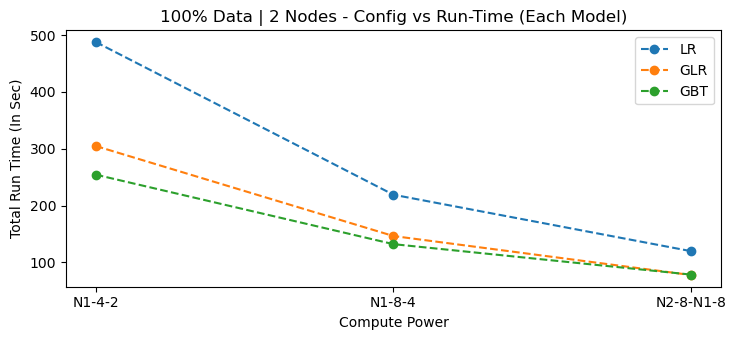

In [65]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


scale_up_pdf = scale_up_pdf.sort_values(by=['Config'])

for model in scale_up_pdf.Model.unique():
    plt.plot(scale_up_pdf.Config.unique(), scale_up_pdf[scale_up_pdf.Model == model].Run_Time, linestyle='--', marker='o')

plt.legend(scale_up_pdf.Model.unique())
plt.xlabel("Compute Power")
plt.ylabel("Total Run Time (In Sec)")
plt.title("100% Data | 2 Nodes - Config vs Run-Time (Each Model)")
plt.show()

## Best Algorithm Result

In [68]:
Model_pipeline, _ = get_model_pipeline("GBT")
Model = Model_pipeline.fit(data_train)
pred = Model.transform(data_test)


23/05/10 00:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB
23/05/10 00:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1046.6 KiB
23/05/10 00:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1070.8 KiB
23/05/10 00:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB
23/05/10 00:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB
23/05/10 00:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1139.4 KiB
23/05/10 00:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1159.3 KiB
23/05/10 00:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB
23/05/10 00:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1197.2 KiB
23/05/10 00:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1233.9 KiB
23/05/10 00:01:58 WARN DAGScheduler: Broadcasting large task binary with size 1257.8 KiB
23/05/10 00:01:59 WAR

In [69]:
eval = RegressionEvaluator(labelCol = 'Total_Count')
rmse = eval.evaluate(pred, {eval.metricName:'rmse'})
r2 =eval.evaluate(pred,{eval.metricName:'r2'})

print("RMSE: %.2f" %rmse)
#print("MAE: %.2f" %mae)
print("R2: %.2f" %r2)

RMSE: 28.09
R2: 0.85


Best Model Analysis:
1. The graph provided represents a visual comparison between the predicted daily rides and the actual daily rides for a specific CitiBike station. The purpose of this graph is to assess the performance and accuracy of a predictive model in forecasting ridership patterns. 

 

2. The predictive model incorporated weather data as one of the factors in its analysis. By including weather information such as temperature, precipitation, wind speed, and other relevant variables, the model aimed to improve the accuracy of its predictions. Weather data can have a significant impact on ridership, as people's decisions to use bike-sharing services like CitiBike can be influenced by weather conditions. 

 

3. The model demonstrated a high level of accuracy in capturing both the peaks and valleys in the ridership patterns. This indicates that the model was effective in predicting the days with high ridership as well as the days with low ridership. By accurately capturing these variations, the model provided valuable insights into the demand for bike-sharing services and allowed for better planning and resource allocation. 

 

4. However, there was a specific period on the graph marked as the COVID-19 crisis, during which the model failed to accurately predict the ridership. The COVID-19 crisis, caused by the global pandemic, significantly impacted transportation patterns and behaviors, including the use of bike-sharing services. The unprecedented nature of the pandemic and the resulting restrictions and changes in people's routines made it difficult for the model to account for such a unique situation accurately. As a result, the model's predictions during this period might have deviated from the actual ridership figures, leading to a visible discrepancy on the graph. 

 

Overall, the graph demonstrates the model's success in predicting ridership patterns for a CitiBike station by utilizing weather data. However, it also highlights the limitations of the model when faced with extraordinary events like the COVID-19 crisis, where predicting ridership accurately becomes challenging due to unprecedented changes in transportation behavior. 

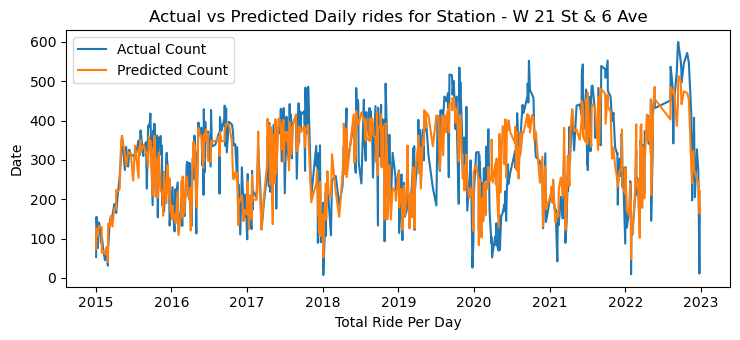

In [70]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

pred_pd = pred.filter(F.col("Station") == "W 21 St & 6 Ave").orderBy("Date").toPandas()
pred_pd = pred.filter(F.col("Station") == "W 21 St & 6 Ave").orderBy("Date").toPandas()


plt.plot(pred_pd.Date, pred_pd.Total_Count)
plt.plot(pred_pd.Date, pred_pd.prediction)

plt.title("Actual vs Predicted Daily rides for Station - W 21 St & 6 Ave")

plt.legend(["Actual Count", "Predicted Count"])
plt.xlabel("Total Ride Per Day")
plt.ylabel("Date")
plt.show()

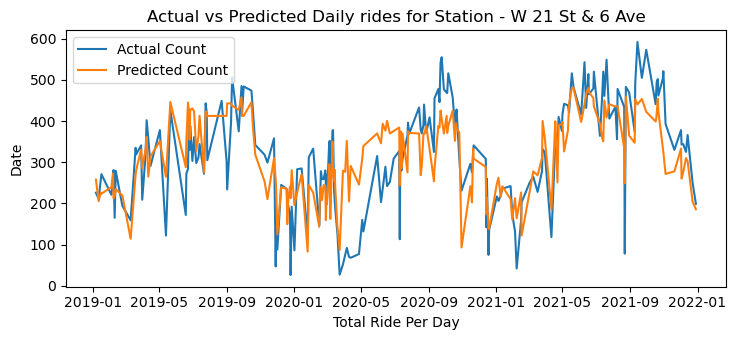

In [106]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#pred_pd = pred.filter(F.col("Station") == "W 21 St & 6 Ave").orderBy("Date").toPandas()
pred_pd = pred.filter((F.col("Station") == "W 21 St & 6 Ave") & (F.col("Year").isin([2019, 2020, 2021]))).orderBy("Date").toPandas()


plt.plot(pred_pd.Date, pred_pd.Total_Count)
plt.plot(pred_pd.Date, pred_pd.prediction)

plt.title("Actual vs Predicted Daily rides for Station - W 21 St & 6 Ave")

plt.legend(["Actual Count", "Predicted Count"])
plt.xlabel("Total Ride Per Day")
plt.ylabel("Date")
plt.show()